In [9]:
"""
https://pytorch.org/examples/?utm_source=examples&utm_medium=examples-landing
https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/
"""
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import onnx
import onnxruntime as ort
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from lightning.pytorch.loggers import TensorBoardLogger
from torch import utils
from torch.utils.data import Dataset, DataLoader, TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print(torch.__version__)

# tensorboard --logdir ./lightning_logs --host=0.0.0.0
logger = TensorBoardLogger("lightning_logs", name="pred")

Using cuda device
1.13.1


In [10]:
%pwd

'/www/test/pred'

In [11]:
def dataGen1():
    np.random.seed(2)

    T = 20
    L = 1000
    N = 600

    x = np.empty((N, L, 1), 'int64')
    x[:, :, 0] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
    # x[:, :, 1] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
    data = np.sin(x / 1.0 / T).astype('float32')
    torch.save(data, open('traindata.pt', 'wb'))

    return torch.load('traindata.pt')


dataPt1 = dataGen1()


def dataGen2():
    np.random.seed(42)
    data = np.sin(np.linspace(0, 100, 500)) + np.random.normal(0, 0.1, 500) + 50
    data = data.astype(np.float32)
    # 将数据转换为PyTorch张量
    data = torch.from_numpy(data)

    # 定义一个函数，将时间序列数据转换为适用于LSTM的输入格式
    def create_sequences(data, seq_length):
        sequences = []
        for i in range(len(data) - seq_length):
            seq = data[i:i + seq_length + 1]
            # label = data[i + seq_length:i + seq_length + 1]
            # sequences.append([seq.numpy(), label.numpy()])
            # sequences.append(seq.numpy())
            sequences.append([[x] for x in seq.numpy()])

        return np.array(sequences, dtype=np.float32)

    seq_length = 199
    return create_sequences(data, seq_length)


dataPt2 = dataGen2()

dataPt = dataPt2[:, :200]
dataPt = torch.tensor(dataPt, dtype=torch.float32, device=device)

# inputsData = torch.tensor(dataPt[:, :-1], dtype=torch.float32, device=device)
# targetData = torch.tensor(dataPt[:, 1:], dtype=torch.float32, device=device)
inputsData, targetData = dataPt[:, :199], dataPt[:, 199]

print(dataPt1.shape, dataPt.shape)
print(inputsData.shape, targetData.shape)
dataset = TensorDataset(inputsData, targetData)

# print(dataset[1], dataset2[1])

(600, 1000, 1) torch.Size([301, 200, 1])
torch.Size([301, 199, 1]) torch.Size([301, 1])


In [144]:
class MyDataModule(pl.LightningDataModule):
    def __init__(self, trainSet, batchSize: int):
        super().__init__()
        self.batchSize = batchSize

        self.trainSet, self.validSet, self.testsSet = utils.data.random_split(trainSet, [0.7, 0.2, 0.1])
        # print(dir(self.trainSet))
        print('dataset num', len(self.trainSet), len(self.validSet), len(self.testsSet))

    def train_dataloader(self):
        return DataLoader(self.trainSet, batch_size=self.batchSize, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.validSet, batch_size=self.batchSize, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.testsSet, batch_size=self.batchSize, shuffle=True)


class MyModel(pl.LightningModule):
    def __init__(self, lr: float):
        super().__init__()
        self.save_hyperparameters("lr")

        self.training_step_outputs = []
        self.metricA1 = torchmetrics.regression.MeanSquaredError()
        self.metricB1 = torchmetrics.regression.MeanSquaredError()
        self.metricC1 = torchmetrics.regression.MeanSquaredError()

        self.seqWidth = 199 # xShape[1]
        nx = 1
        self.num_layers = 2
        self.hidden_size = 51

        self.lstm1 = nn.LSTM(input_size=nx, hidden_size=self.hidden_size, num_layers=self.num_layers, dropout=0.2, batch_first=True)
        self.bn1 = nn.BatchNorm1d(self.seqWidth)
        self.fc1 = nn.Linear(self.hidden_size, nx)

        self.h0 = (torch.zeros(self.num_layers, 1, self.hidden_size).to(device),
                   torch.zeros(self.num_layers, 1, self.hidden_size).to(device))

        self.criterion = nn.MSELoss(reduction='mean')

    def init_hidden(self, batch_size):
        self.h0 = (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                   torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

    def forward(self, x):
        # print('forward.x', x.shape) # (batch, w, x)
        x, hx = self.lstm1(x, self.h0)
        x = self.bn1(x)
        x = x[:, -1, :]
        # print('forward.output', x.shape) # (batch, w, x)
        y = self.fc1(x)  # (70, 2)
        return y

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 100], gamma=0.1, verbose=True)
        return {
            "optimizer": optimizer,
            # "lr_scheduler": {
            #     "scheduler": scheduler,
            # },
        }

    def training_step(self, batch, batch_idx):
        inputs, target = batch
        self.init_hidden(len(inputs))
        outputs = self.forward(inputs)
        loss = self.criterion(outputs, target)

        self.metricA1.update(outputs, target)
        self.log("1/a", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, target = batch
        # inputs, target = self.scaler.transform(inputs), self.scaler.transform(target)
        self.init_hidden(len(inputs))
        outputs = self.forward(inputs)
        # print("in out target .shape", inputs.shape, outputs.shape, target.shape)
        loss = self.criterion(outputs, target)

        self.metricB1.update(outputs, target)
        self.log("1/b", loss, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        inputs, target = batch
        self.init_hidden(len(inputs))
        outputs = self.forward(inputs)
        loss = self.criterion(outputs, target)

        self.metricC1.update(outputs, target)
        self.log("1/c", loss, on_step=False, on_epoch=True)

    def on_train_epoch_end(self):
        print('epoch.{}.train.loss {:.6f}'.format(self.current_epoch, torch.mean(self.metricA1.compute()).item()))
        self.metricA1.reset()

    def on_validation_epoch_end(self):
        print('epoch.{}.valid.loss {:.6f}'.format(self.current_epoch, torch.mean(self.metricB1.compute()).item()))
        self.metricB1.reset()

    def on_test_epoch_end(self):
        print('epoch.{}.test..loss {:.6f}'.format(self.current_epoch, torch.mean(self.metricC1.compute()).item()))
        self.metricC1.reset()


# dataset = custom_transform(dataset)
dm = MyDataModule(dataset, batchSize=64)
model = MyModel(lr=0.001)
# model.cpu()

trainer = pl.Trainer(logger=logger, max_epochs=300, enable_progress_bar=False, enable_checkpointing=False)
trainer.fit(model, datamodule=dm)
trainer.test(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | metricA1  | MeanSquaredError | 0     
1 | metricB1  | MeanSquaredError | 0     
2 | metricC1  | MeanSquaredError | 0     
3 | lstm1     | LSTM             | 32.2 K
4 | bn1       | BatchNorm1d      | 398   
5 | fc1       | Linear           | 52    
6 | criterion | MSELoss          | 0     
-----------------------------------------------
32.7 K    Trainable params
0         Non-trainable params
32.7 K    Total params
0.131     Total estimated model params size (MB)


dataset num 211 60 30
epoch.0.valid.loss 2484.446289
epoch.0.valid.loss 2451.347900
epoch.0.train.loss 2459.082764
epoch.1.valid.loss 2402.730713
epoch.1.train.loss 2319.387695
epoch.2.valid.loss 2340.323242
epoch.2.train.loss 2225.277344
epoch.3.valid.loss 2271.429688
epoch.3.train.loss 2164.541504
epoch.4.valid.loss 2198.886230
epoch.4.train.loss 2121.923828
epoch.5.valid.loss 2131.605469
epoch.5.train.loss 2091.745605
epoch.6.valid.loss 2079.925781
epoch.6.train.loss 2067.610596
epoch.7.valid.loss 2039.075073
epoch.7.train.loss 2046.565430
epoch.8.valid.loss 2012.779541
epoch.8.train.loss 2026.542114
epoch.9.valid.loss 1984.088013
epoch.9.train.loss 2006.256958
epoch.10.valid.loss 1961.820679
epoch.10.train.loss 1985.649292
epoch.11.valid.loss 1933.309692
epoch.11.train.loss 1965.355469
epoch.12.valid.loss 1909.973755
epoch.12.train.loss 1945.140137
epoch.13.valid.loss 1882.930420
epoch.13.train.loss 1924.999023
epoch.14.valid.loss 1860.770874
epoch.14.train.loss 1904.913818
epoch.1

`Trainer.fit` stopped: `max_epochs=300` reached.


epoch.291.valid.loss 0.013329
epoch.291.train.loss 0.025063
epoch.292.valid.loss 0.034392
epoch.292.train.loss 0.030902
epoch.293.valid.loss 0.023343
epoch.293.train.loss 0.025812
epoch.294.valid.loss 0.027459
epoch.294.train.loss 0.026440
epoch.295.valid.loss 0.014866
epoch.295.train.loss 0.037562
epoch.296.valid.loss 0.025016
epoch.296.train.loss 0.033296
epoch.297.valid.loss 0.011538
epoch.297.train.loss 0.041495
epoch.298.valid.loss 0.011817
epoch.298.train.loss 0.023457
epoch.299.valid.loss 0.011634
epoch.299.train.loss 0.032924


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


epoch.300.test..loss 0.008824


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            1/c            │   0.008823770098388195    │
└───────────────────────────┴───────────────────────────┘

[{'1/c': 0.008823770098388195}]

MyModel(
  (metricA1): MeanSquaredError()
  (metricB1): MeanSquaredError()
  (metricC1): MeanSquaredError()
  (lstm1): LSTM(1, 51, num_layers=2, batch_first=True, dropout=0.2)
  (bn1): BatchNorm1d(199, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=51, out_features=1, bias=True)
  (criterion): MSELoss()
)


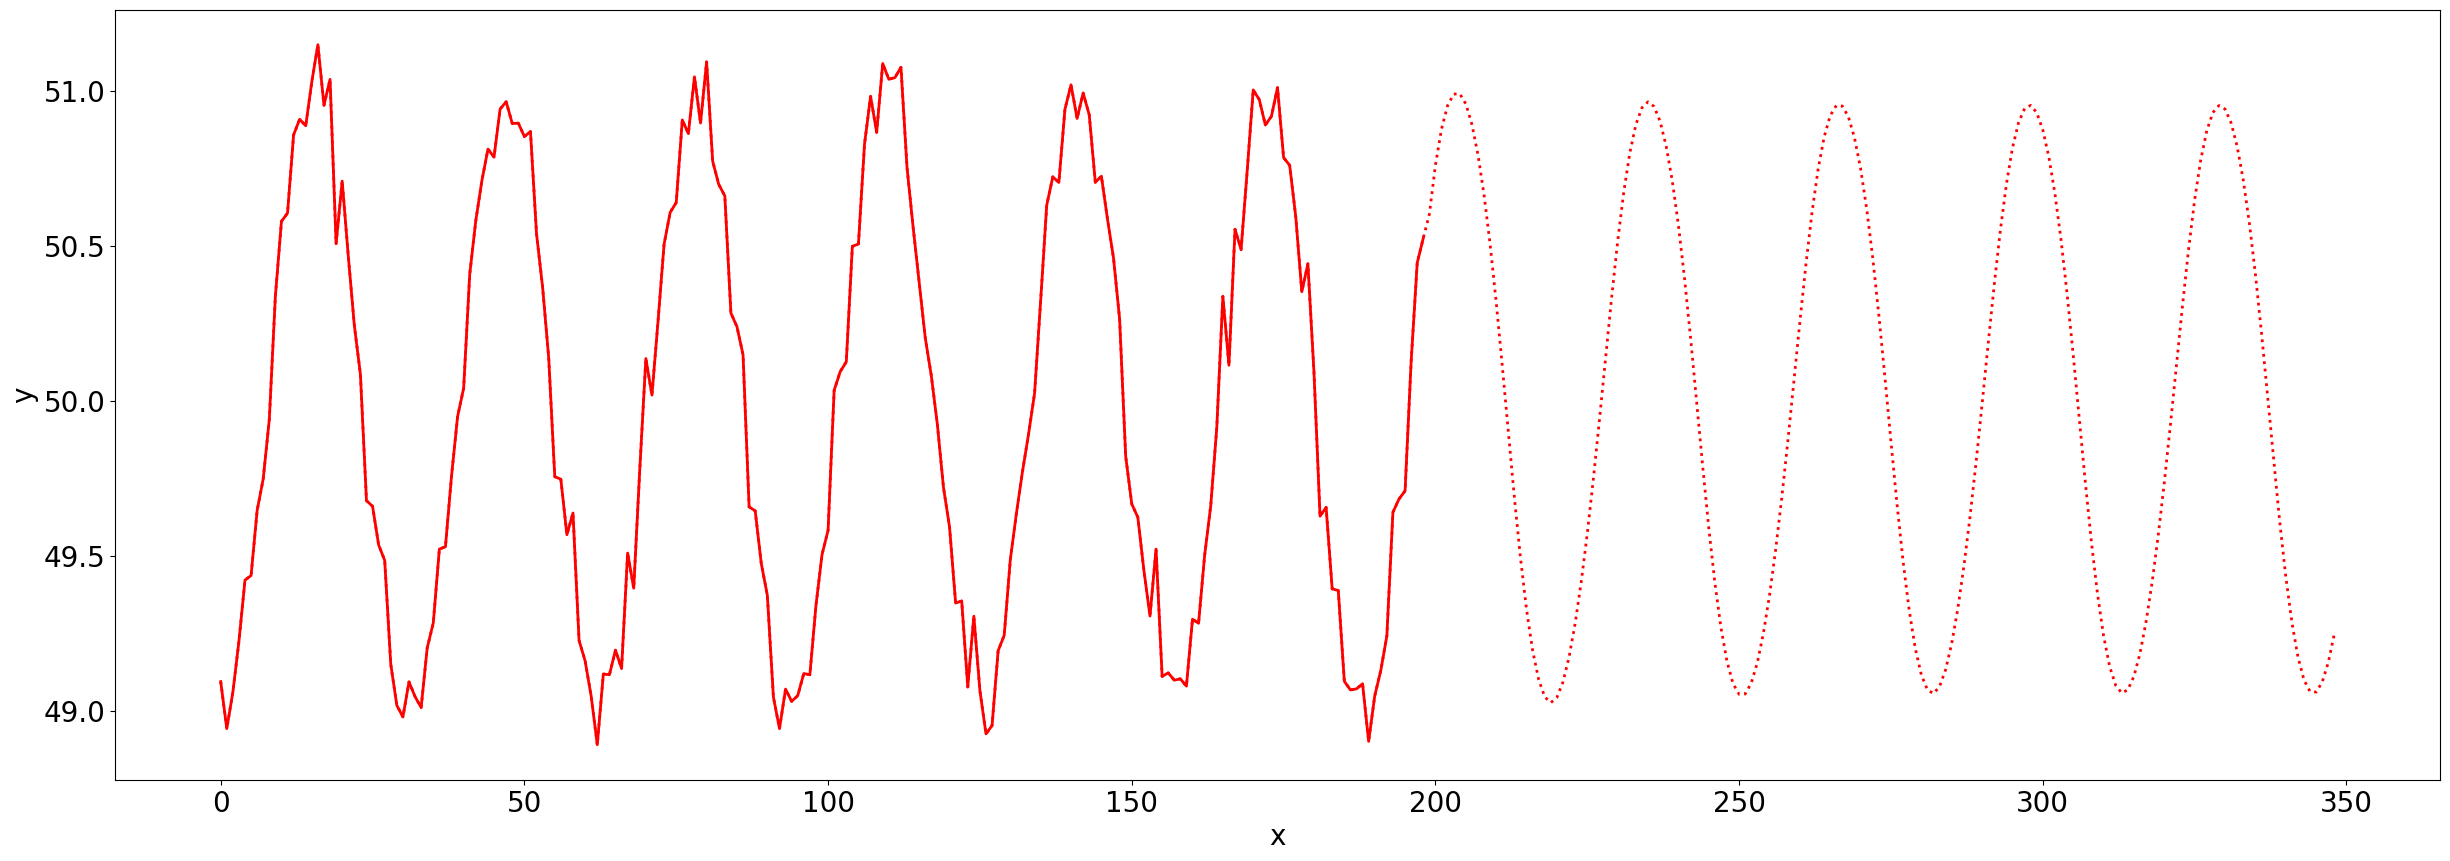

In [145]:
plt.figure(figsize=(30, 10))
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

model.cuda()
model.eval()
print(model)

w = 199
wPred = 150


def draw(row, color):
    xi: torch.Tensor
    xi, _ = row[0], row[1]
    xd = xi.size(0)  # 999
    # print(xi.shape)

    future_data = xi.cpu()
    future_seq = future_data[-w:].unsqueeze(0)
    # future_seq = scaler2.transform(future_seq.cuda()).cpu()
    model.init_hidden(1)
    for i in range(wPred):
        future_in = future_seq[:, -w:]
        future_pred = model(future_in.cuda())
        # print('more1', future_seq.shape, future_pred.shape, future_pred[:, -1:].shape)
        # future_seq = torch.cat((future_seq, future_pred.unsqueeze(0)), dim=1)
        # future_pred = scaler2.inverse_transform(future_pred)
        future_pred = future_pred.unsqueeze(0)
        future_seq = torch.cat((future_seq, future_pred.cpu()), dim=1)

    future_data = future_seq.squeeze(0)
    # future_data = scaler2.inverse_transform(future_seq.squeeze(0).cuda()).cpu()
    future_data = future_data.detach().numpy()
    # print(future_data.shape)
    # model1 = model(xi.unsqueeze(0).cuda())
    # future_data = model1.cpu().squeeze(0).detach()

    # print('xi, yi', xi.shape, yi.shape)
    plt.plot(np.arange(xd), xi.cpu()[:, 0], color, linewidth=2.0)
    plt.plot(np.arange(w + wPred), future_data[:, 0], color + ':', linewidth=2.0)


draw(dataset[55], 'r')
# draw(dataset[2], 'g')
# draw(dataset[3], 'b')
# draw(dataset[5], 'y')
# draw(dataset[6], 'y')
# draw(dataset[7], 'y')

In [14]:
"""
/etc/conda/lib/python3.9/site-packages/torch/onnx/symbolic_opset9.py:4315: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
/etc/conda/lib/python3.9/site-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/etc/conda/lib/python3.9/site-packages/torch/onnx/utils.py:687: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/etc/conda/lib/python3.9/site-packages/torch/onnx/utils.py:1178: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_graph_shape_type_inference(
"""
model.cuda()
print(model)

inputs = torch.randn(1, 199, 1).cpu()
model.init_hidden(1)
model.to_onnx('a.onnx',
              input_sample=inputs,
              export_params=True,
              input_names=['input'],
              output_names=['output'],
              dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
              )

MyModel(
  (metricA1): MeanSquaredError()
  (metricB1): MeanSquaredError()
  (metricC1): MeanSquaredError()
  (lstm1): LSTM(1, 81, batch_first=True)
  (bn): BatchNorm1d(199, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=81, out_features=1, bias=True)
  (criterion): MSELoss()
)


In [15]:
onnx_model = onnx.load('a.onnx')
print(onnx_model.graph.input[0])

name: "input"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "batch_size"
      }
      dim {
        dim_value: 199
      }
      dim {
        dim_value: 1
      }
    }
  }
}


NodeArg(name='input', type='tensor(float)', shape=['batch_size', 199, 1])
NodeArg(name='output', type='tensor(float)', shape=['batch_size', 1])
(399, 1)


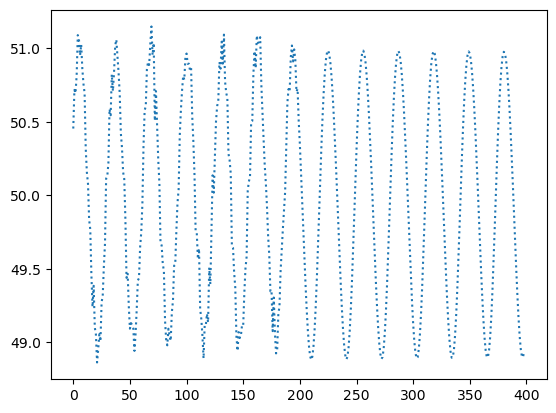

In [16]:
sess = ort.InferenceSession("a.onnx")

for one in sess.get_inputs():
    print(one)
for one in sess.get_outputs():
    print(one)

yy: np.ndarray = dataset[2][0].cpu().detach().numpy()
result = sess.run(None, {"input": [yy]})[0]
for i in range(200):
    output: np.ndarray = sess.run(None, {"input": [yy[-w:]]})[0].squeeze(0)
    yy = np.append(yy, [output], axis=0)
print(yy.shape)

plt.plot(yy, ':')